# Latent state estimation (filtering) for an irregularly-sampled, continuous-discrete (non-linear) Gaussian dynamical system

We show how to use cd-dynamax to estimate the latent state of a continuous-discrete (non-linear) Gaussian dynamical system

Specifically, we will showcase the following filtering alternatives:

- The Extended Kalman Filter (EKF)
- The Ensemble Kalman Filter (EnKF)
- The Unscented Kalman filter

## Preliminaries

### Code Setup

In [1]:
# Main imports
import sys
from itertools import count

# Import jax and utils
from jax import numpy as jnp
import jax.random as jr
from jaxtyping import Float, Array
from typing import Callable, NamedTuple, Tuple, Optional, Union
from jaxtyping import Array, Float

# Additional, custom codebase
sys.path.append("../..")
sys.path.append("../../..")

# Import dynamax
from dynamax.parameters import ParameterProperties
# import discrete-time filters
from dynamax.nonlinear_gaussian_ssm import ParamsNLGSSM, UKFHyperParams
from dynamax.nonlinear_gaussian_ssm import extended_kalman_smoother, unscented_kalman_smoother

# Our own custom src codebase
# continuous-discrete nonlinear Gaussian SSM codebase
from continuous_discrete_nonlinear_gaussian_ssm import ContDiscreteNonlinearGaussianSSM
from continuous_discrete_nonlinear_gaussian_ssm import cdnlgssm_filter, cdnlgssm_forecast
# Load models
from continuous_discrete_nonlinear_gaussian_ssm.models import *

# Plotting
import matplotlib
%matplotlib inline
# Our own custom plotting codebase
from utils.plotting_utils import *
from lorenz_plotting import *
# Feel free to change the default figure size
#matplotlib.rcParams['figure.figsize'] = [16, 9]

# For pretty print of ndarrays
jnp.set_printoptions(formatter={"float_kind": "{:.2f}".format})

Jax plugin configuration error: Exception when calling jax_plugins.xla_cuda12.initialize()
Traceback (most recent call last):
  File "/home/iurteaga/miniconda3/envs/hduq_nodynamax/lib/python3.11/site-packages/jax/_src/xla_bridge.py", line 430, in discover_pjrt_plugins
    plugin_module.initialize()
  File "/home/iurteaga/miniconda3/envs/hduq_nodynamax/lib/python3.11/site-packages/jax_plugins/xla_cuda12/__init__.py", line 85, in initialize
    options = xla_client.generate_pjrt_gpu_plugin_options()
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AttributeError: module 'jaxlib.xla_client' has no attribute 'generate_pjrt_gpu_plugin_options'
No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)
/home/iurteaga/miniconda3/envs/hduq_nodynamax/lib/python3.11/site-packages/equinox/_ad.py:733: UserWarning: As of Equinox 0.10.7, `equinox.filter_custom_vjp.defvjp` is deprecated in favour of `.def_fwd` and `.def_bwd`. This new API supports symbolic z

In [2]:
# Compute RMSE
def compute_rmse(y, y_est):
    return jnp.sqrt(jnp.sum((y - y_est) ** 2) / len(y))

# Compute RMSE of estimate and print comparison with
# standard deviation of measurement noise
def compute_and_print_rmse_comparison(y, y_est, R, est_type=""):
    rmse_est = compute_rmse(y, y_est)
    print(f'{f"The RMSE of the {est_type} estimate is":<40}: {rmse_est:.2f}')
    print(f'{"The std of measurement noise is":<40}: {jnp.sqrt(R):.2f}')

## True model set up

We generate data from a Lorenz 63 system, from dynamics with the following stochastic differential equations:

\begin{align*}
\frac{d x}{d t} &= a(y-x) + \sigma w_x(t) \\
\frac{d y}{d t} &= x(b-z) - y + \sigma w_y(t) \\
\frac{d z}{d t} &= xy - cz + \sigma w_z(t),
\end{align*}

With parameters $a=10, b=28, c=8/3$, the system gives rise to chaotic behavior, and we choose $\sigma=0.1$ for light diffusion.

To generate data, we numerically approximate random path solutions to this SDE using Heun's method (i.e. improved Euler), as implemented in [Diffrax](https://docs.kidger.site/diffrax/api/solvers/sde_solvers/).


We assume the observation model is
\begin{align*}
y(t) &= H x(t) + r(t) \\
r(t) &\sim N(0,R),
\end{align*}
where we choose $R=I$. 

Namely, we impose partial observability with H=[1, 0, 0], with noisy observations, sampled at irregular time intervals.

### True, data-generating model definition

In [3]:
## Main settings
state_dim = 3
emission_dim = 1

# Define a custom drift model, inherited from LearnableFunction
class lorenz63_drift(LearnableFunction):
    params: Union[Float[Array, "state_dim"], ParameterProperties]

    def f(self, x, u=None, t=None):
        foo = jnp.array(
            [
                self.params[0] * (x[1] - x[0]),
                self.params[1] * x[0] - x[1] - x[0] * x[2],
                -self.params[2] * x[2] + x[0] * x[1],
            ]
        )
        return foo

# Define the true parameters of the drift function
true_l63_drift_params = jnp.array([10.0, 28.0, 8 / 3])
# And the corresponding Lorenz 63 system
true_drift = {
    "params": lorenz63_drift(
        params=true_l63_drift_params
    ),
    "props": lorenz63_drift(
        params=ParameterProperties()
    ),
}

# Define the true parameters of the diffusion function
true_diffusion_cov = {
    "params": LearnableMatrix(
        params=jnp.eye(state_dim)
    ),
    "props": LearnableMatrix(
        params=ParameterProperties(
            constrainer=RealToPSDBijector()
        )
    ),
}

# Define the true parameters of the diffusion function
true_diffusion_coefficient_param = 0.1
true_diffusion_coefficient = {
    "params": LearnableMatrix(
        params=true_diffusion_coefficient_param * jnp.eye(state_dim)
    ),
    "props": LearnableMatrix(
        params=ParameterProperties()
    ),
}

# Define the true parameters of the emission function
# Partial observability
H=jnp.array(
    [[1.0, 0.0, 0.0]]
)
true_emission = {
    "params": LearnableLinear(
        weights=H,
        bias=jnp.zeros(emission_dim)
    ),
    "props": LearnableLinear(
        weights=ParameterProperties(),
        bias=ParameterProperties()
    ),
}

# Define the true parameters of the emission covariance
R=jnp.eye(emission_dim)
true_emission_cov = {
    "params": LearnableMatrix(
        params=R
    ),
    "props": LearnableMatrix(
        params=ParameterProperties(
            constrainer=RealToPSDBijector()
        )
    ),
}

# Define the true initial mean and covariance
true_initial_mean = {
    "params": LearnableVector(
        params=jnp.zeros(state_dim)
    ),
    "props": LearnableVector(
        params=ParameterProperties()
    ),
}

true_initial_cov_param = 10.0
true_initial_cov = {
    "params": LearnableMatrix(
        params=true_initial_cov_param*jnp.eye(state_dim)
    ),
    "props": LearnableMatrix(
        params=ParameterProperties(
            constrainer=RealToPSDBijector()
        )
    ),
}

# Concatenate all parameters in dictionary, for later easy use
all_true_params = {
    'initial_mean': true_initial_mean,
    'initial_cov': true_initial_cov,
    'dynamics_drift': true_drift,
    'dynamics_diffusion_coefficient': true_diffusion_coefficient,
    'dynamics_diffusion_cov': true_diffusion_cov,
    'dynamics_approx_order': 2., # Check on this later
    'emission_function': true_emission,
    'emission_cov': true_emission_cov,
}

# Simulation 1: Fast sample rate and modest initial state covariance

### Simulation set-up

In [4]:
# Simulation parameters
T = 40
num_timesteps = 4000

# We collect measurements at irregular times sampled uniformly from a time domain $[0,40]$.
sim1_t_emissions = jnp.array(
        sorted(
            jr.uniform(
                jr.PRNGKey(0),
                (num_timesteps, 1),
                minval=0,
                maxval=T
            )
        )
    )
# drop duplicates
sim1_t_emissions = jnp.unique(sim1_t_emissions)[:, None]
sim1_num_timesteps = len(sim1_t_emissions)

# Set up seed for simulation
keys = map(jr.PRNGKey, count())

### Model creation: object instantiation, with modest initial state covariance

In [5]:
sim1_state_sd = 10.0
sim1_initial_cov_param = {
    "params": LearnableMatrix(
        params=sim1_state_sd**2 *jnp.eye(state_dim)
    ),
    "props": LearnableMatrix(
        params=ParameterProperties(
            constrainer=RealToPSDBijector()
        )
    ),
}

# Concatenate all parameters in dictionary, for later easy use
all_sim1_params = {
    'initial_mean': true_initial_mean,
    'initial_cov': sim1_initial_cov_param,
    'dynamics_drift': true_drift,
    'dynamics_diffusion_coefficient': true_diffusion_coefficient,
    'dynamics_diffusion_cov': true_diffusion_cov,
    'dynamics_approx_order': 2., # Check on this later
    'emission_function': true_emission,
    'emission_cov': true_emission_cov,
}

# Create CD-NLGSSM model
sim1_model = ContDiscreteNonlinearGaussianSSM(state_dim, emission_dim)
sim1_params, _ = sim1_model.initialize(
    next(keys),
    **all_sim1_params
)

### Simulate data: sample from model

In [6]:
# sample true states and emissions from defined true model.
# Using transition_type="path" to solve the dynamics SDE.
sim1_states, sim1_emissions = sim1_model.sample(
    sim1_params,
    next(keys),
    sim1_num_timesteps,
    sim1_t_emissions,
    transition_type="path" # uses the Euler-Maruyama method
)

Sampling from SDE solver path (this may be an unnecessarily poor approximation if you're simulating from a linear SDE). It is an appropriate choice for non-linear SDEs.


### Plot generated data

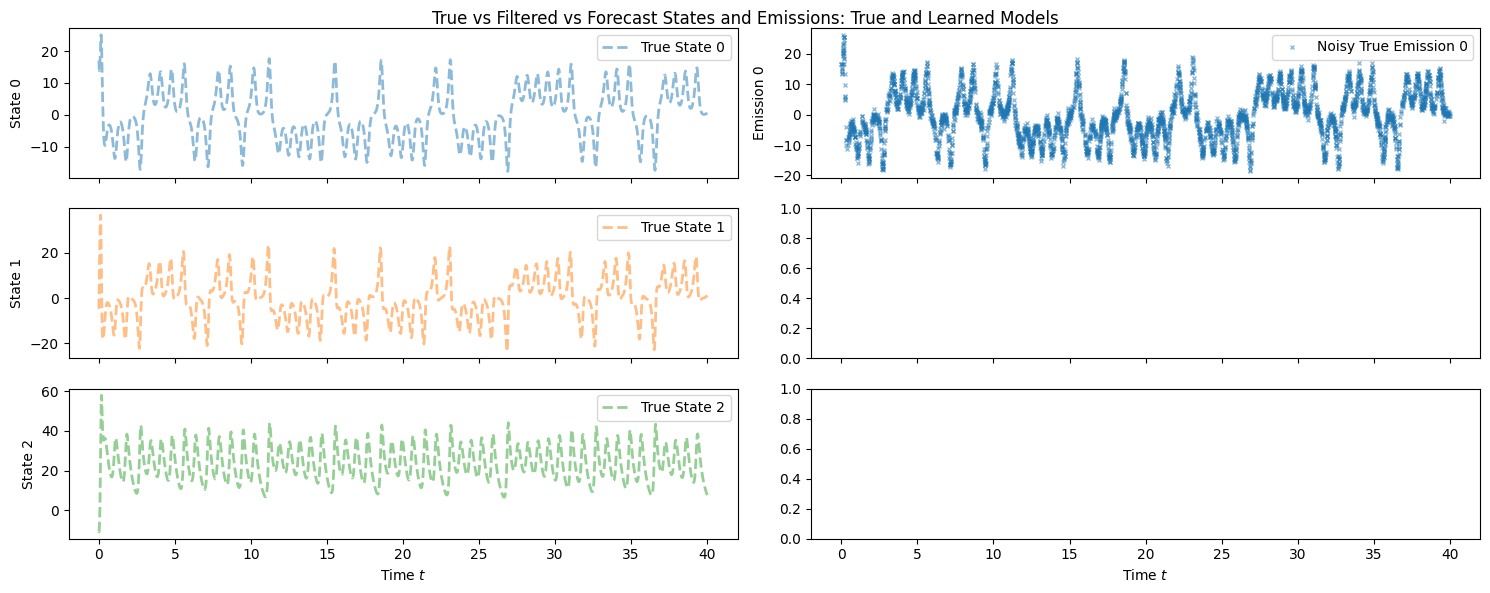

In [8]:
plot_lorenz_estimates(
    time_grid_all=sim1_t_emissions,
    true_states=sim1_states,
    true_emissions_noisy=sim1_emissions,
    emission_function=sim1_params.emissions.emission_function
)

### State estimation with Extended Kalman Filter

In [9]:
# Filter: EKF
from continuous_discrete_nonlinear_gaussian_ssm import EKFHyperParams

In [10]:
# Execute the EKF filter
sim1_ekf_filtered = cdnlgssm_filter(
    sim1_params,
    sim1_emissions,
    sim1_t_emissions,
    hyperparams=EKFHyperParams()
)


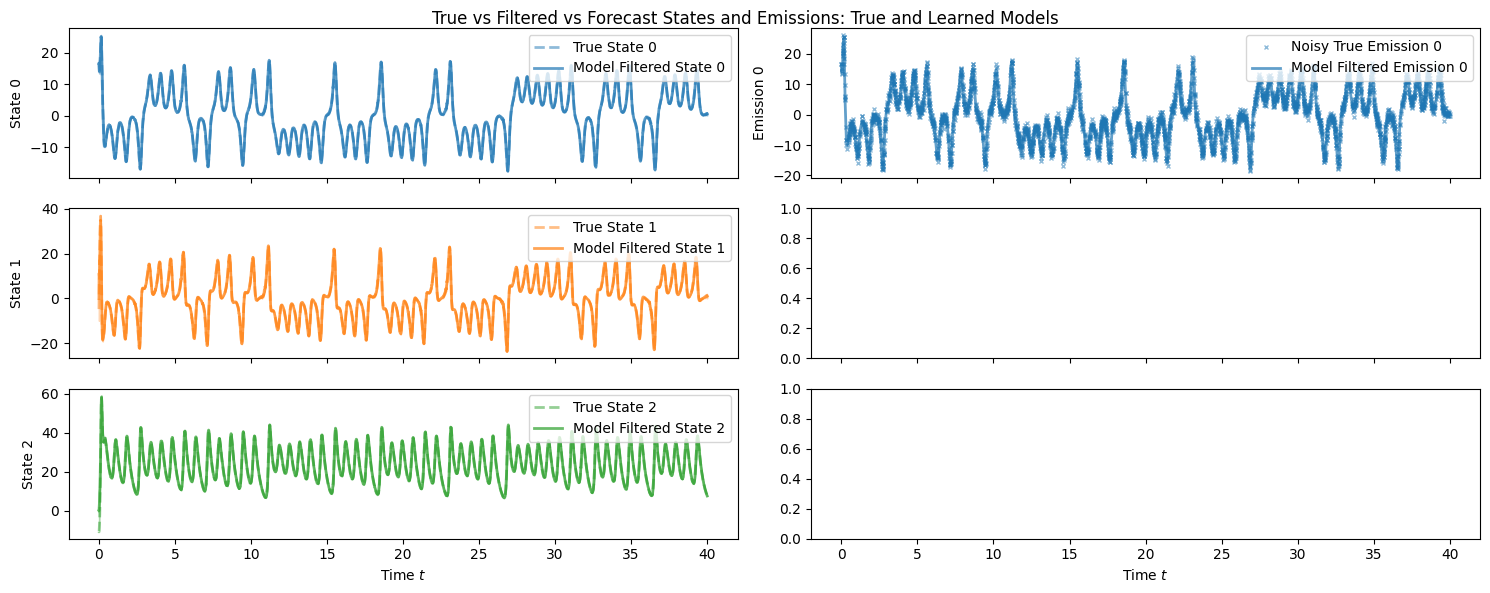

In [12]:
# Plot the true states and emissions, and the EKF estimates
plot_lorenz_estimates(
        time_grid_all=sim1_t_emissions,
        true_states=sim1_states,
        true_emissions_noisy=sim1_emissions,
        emission_function=sim1_params.emissions.emission_function,
        time_grid_filter=sim1_t_emissions,
        model_filtered_states=sim1_ekf_filtered.filtered_means,
        model_filtered_covariances=sim1_ekf_filtered.filtered_covariances,
        t_start=None,
        t_end=None,
    )

In [13]:
### Compute and print RMSE between true states and EKF estimates
compute_and_print_rmse_comparison(
    sim1_states[:, -1],
    sim1_ekf_filtered.filtered_means[:,-1],
    1,
    "EKF"
)

The RMSE of the EKF estimate is         : 0.62
The std of measurement noise is         : 1.00


In [16]:
# EKF forecasting
# Initialize at last filtered state
from tensorflow_probability.substrates.jax.distributions import MultivariateNormalFullCovariance as MVN
init_forecast = MVN(
    sim1_ekf_filtered.filtered_means[-1,:],
    sim1_ekf_filtered.filtered_covariances[-1,:]
)

# With this mean and covariance
print(init_forecast.mean())
print(init_forecast.covariance())


[0.47 0.91 7.57]
[[0.19 0.37 0.03]
 [0.37 0.71 0.06]
 [0.03 0.06 0.01]]


In [17]:
# Set-up forecasting time points
T_forecast = 50
num_forecast_timesteps = 100

# We collect measurements at irregular times sampled uniformly from a time domain $[0,40]$.
sim1_t_forecasting = jnp.array(
        sorted(
            jr.uniform(
                jr.PRNGKey(0),
                (num_forecast_timesteps, 1),
                minval=T,
                maxval=T_forecast
            )
        )
    )
# drop duplicates
sim1_t_forecasting = jnp.unique(sim1_t_forecasting)[:, None]
sim1_num_forecast_timesteps = len(sim1_t_forecasting)

In [18]:
# Execute the EKF forecast, using the last filtered state as initial forecast
sim1_ekf_forecast = cdnlgssm_forecast(
    params = sim1_params,
    init_forecast = init_forecast,
    t_emissions=sim1_t_forecasting,
    hyperparams=EKFHyperParams()
)

In [27]:
sim1_ekf_forecast.forecasted_emission_covariances.shape

(100, 1, 1)

ValueError: x and y must have same first dimension, but have shapes (3999,) and (100,)

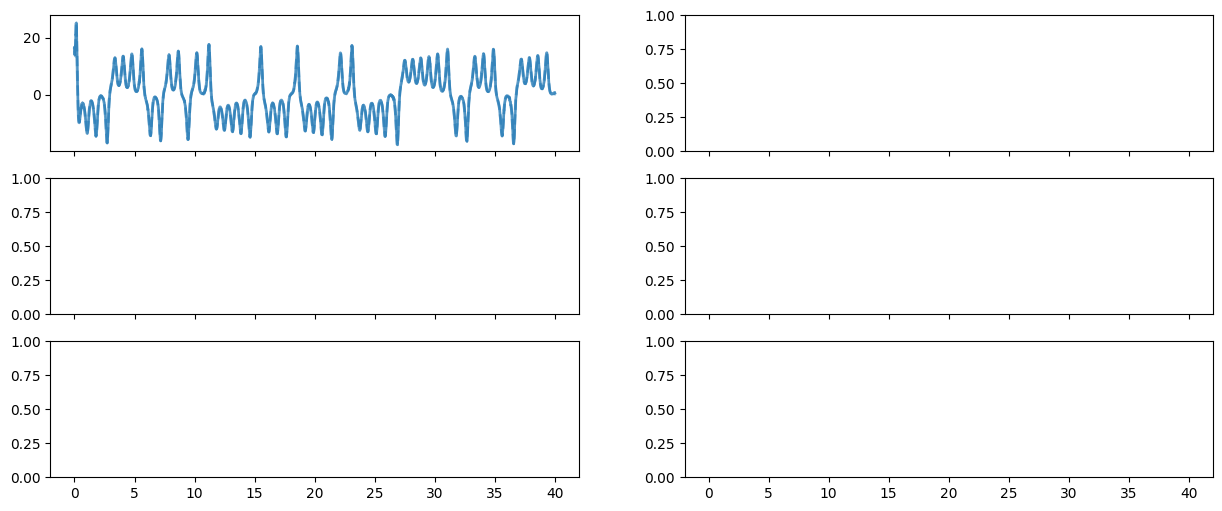

In [28]:
# Plot the true states and emissions, and the EKF estimates
plot_lorenz_estimates(
        time_grid_all=sim1_t_emissions,
        true_states=sim1_states,
        true_emissions_noisy=sim1_emissions,
        emission_function=sim1_params.emissions.emission_function,
        time_grid_filter=sim1_t_emissions,
        model_filtered_states=sim1_ekf_filtered.filtered_means,
        model_filtered_covariances=sim1_ekf_filtered.filtered_covariances,
        time_grid_forecast=sim1_t_forecasting,
        model_forecast_states=sim1_ekf_forecast.forecasted_state_means,
        #model_forecast_covariances=sim1_ekf_forecast.forecasted_state_covariances,
        t_start=None,
        t_end=None,
    )

### State estimation with Ensemble Kalman Filter

In [15]:
# Filter: EnKF
from continuous_discrete_nonlinear_gaussian_ssm import EnKFHyperParams

In [16]:
# Execute the EnKF filter
sim1_enkf_filtered = cdnlgssm_filter(
    sim1_params,
    sim1_emissions,
    sim1_t_emissions,
    hyperparams=EnKFHyperParams()
)


In [ ]:
# Plot the true states and emissions, and the EKF estimates
plot_lorenz_estimates(
    sim1_t_emissions,
    sim1_states,
    sim1_emissions,
    x_est=sim1_enkf_filtered.filtered_means,
    x_unc=sim1_enkf_filtered.filtered_covariances,
    est_type="EnKF"
)

In [ ]:
### Compute and print RMSE between true states and EKF estimates
compute_and_print_rmse_comparison(
    sim1_states[:, -1],
    sim1_enkf_filtered.filtered_means[:,-1],
    1,
    "EnKF"
)

### State estimation with Uscented Kalman Filter

In [19]:
# Filter: UKF
from continuous_discrete_nonlinear_gaussian_ssm import UKFHyperParams

In [20]:
# Execute the UKF filter
sim1_ukf_filtered = cdnlgssm_filter(
    sim1_params,
    sim1_emissions,
    sim1_t_emissions,
    hyperparams=UKFHyperParams()
)


In [ ]:
# Plot the true states and emissions, and the UKF estimates
plot_lorenz_estimates(
    sim1_t_emissions,
    sim1_states,
    sim1_emissions,
    x_est=sim1_ukf_filtered.filtered_means,
    x_unc=sim1_ukf_filtered.filtered_covariances,
    est_type="UKF"
)

In [ ]:
### Compute and print RMSE between true states and EKF estimates
compute_and_print_rmse_comparison(
    sim1_states[:, -1],
    sim1_ukf_filtered.filtered_means[:,-1],
    1,
    "UKF"
)

# Simulation 2: Slow sample rate and larger initial state covariance

### Simulation set-up

In [23]:
# Simulation parameters
T = 40
num_timesteps = 400

# We collect measurements at irregular times sampled uniformly from a time domain $[0,40]$.
sim2_t_emissions = jnp.array(
        sorted(
            jr.uniform(
                jr.PRNGKey(0),
                (num_timesteps, 1),
                minval=0,
                maxval=T
            )
        )
    )
# drop duplicates
sim2_t_emissions = jnp.unique(sim2_t_emissions)[:, None]
sim2_num_timesteps = len(sim2_t_emissions)

# Set up seed for simulation
keys = map(jr.PRNGKey, count())

### Model creation: object instantiation, with modest initial state covariance

In [24]:
sim2_state_sd = 20.0
sim2_initial_cov_param = {
    "params": LearnableMatrix(
        params=sim2_state_sd**2 *jnp.eye(state_dim)
    ),
    "props": LearnableMatrix(
        params=ParameterProperties(
            constrainer=RealToPSDBijector()
        )
    ),
}

# Concatenate all parameters in dictionary, for later easy use
all_sim2_params = {
    'initial_mean': true_initial_mean,
    'initial_cov': sim2_initial_cov_param,
    'dynamics_drift': true_drift,
    'dynamics_diffusion_coefficient': true_diffusion_coefficient,
    'dynamics_diffusion_cov': true_diffusion_cov,
    'dynamics_approx_order': 2., # Check on this later
    'emission_function': true_emission,
    'emission_cov': true_emission_cov,
}

# Create CD-NLGSSM model
sim2_model = ContDiscreteNonlinearGaussianSSM(state_dim, emission_dim)
sim2_params, _ = sim1_model.initialize(
    next(keys),
    **all_sim1_params
)

### Simulate data: sample from model

In [ ]:
# sample true states and emissions from defined true model.
# Using transition_type="path" to solve the dynamics SDE.
sim2_states, sim2_emissions = sim2_model.sample(
    sim2_params,
    next(keys),
    sim2_num_timesteps,
    sim2_t_emissions,
    transition_type="path" # uses the Euler-Maruyama method
)

### Plot generated data

In [ ]:
plot_lorenz(
    sim2_t_emissions,
    sim2_states,
    sim2_emissions
)

### State estimation with Extended Kalman Filter

In [27]:
# Filter: EKF
from continuous_discrete_nonlinear_gaussian_ssm import EKFHyperParams

In [28]:
# Execute the EKF filter
sim2_ekf_filtered = cdnlgssm_filter(
    sim2_params,
    sim2_emissions,
    sim2_t_emissions,
    hyperparams=EKFHyperParams()
)


In [ ]:
# Plot the true states and emissions, and the EKF estimates
plot_lorenz_estimates(
    sim2_t_emissions,
    sim2_states,
    sim2_emissions,
    x_est=sim2_ekf_filtered.filtered_means,
    x_unc=sim2_ekf_filtered.filtered_covariances,
    est_type="EKF"
)

In [ ]:
### Compute and print RMSE between true states and EKF estimates
compute_and_print_rmse_comparison(
    sim2_states[:, -1],
    sim2_ekf_filtered.filtered_means[:,-1],
    1,
    "EKF"
)

### State estimation with Ensemble Kalman Filter

In [31]:
# Filter: EnKF
from continuous_discrete_nonlinear_gaussian_ssm import EnKFHyperParams

In [ ]:
# Execute the EnKF filter
sim2_enkf_filtered = cdnlgssm_filter(
    sim2_params,
    sim2_emissions,
    sim2_t_emissions,
    hyperparams=EnKFHyperParams()
)


In [ ]:
# Plot the true states and emissions, and the EKF estimates
plot_lorenz_estimates(
    sim2_t_emissions,
    sim2_states,
    sim2_emissions,
    x_est=sim2_enkf_filtered.filtered_means,
    x_unc=sim2_enkf_filtered.filtered_covariances,
    est_type="EnKF"
)

In [ ]:
### Compute and print RMSE between true states and EKF estimates
compute_and_print_rmse_comparison(
    sim2_states[:, -1],
    sim2_enkf_filtered.filtered_means[:,-1],
    1,
    "EnKF"
)

### State estimation with Uscented Kalman Filter

In [32]:
# Filter: UKF
from continuous_discrete_nonlinear_gaussian_ssm import UKFHyperParams

In [33]:
# Execute the UKF filter
sim2_ukf_filtered = cdnlgssm_filter(
    sim2_params,
    sim2_emissions,
    sim2_t_emissions,
    hyperparams=UKFHyperParams()
)


In [ ]:
# Plot the true states and emissions, and the UKF estimates
plot_lorenz_estimates(
    sim2_t_emissions,
    sim2_states,
    sim2_emissions,
    x_est=sim2_ukf_filtered.filtered_means,
    x_unc=sim2_ukf_filtered.filtered_covariances,
    est_type="UKF"
)

In [ ]:
### Compute and print RMSE between true states and EKF estimates
compute_and_print_rmse_comparison(
    sim2_states[:, -1],
    sim2_ukf_filtered.filtered_means[:,-1],
    1,
    "UKF"
)